In [1]:
import sys
sys.path.append("..")

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro.distributions as dist
import pyro.poutine as poutine

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from tyxe_runfiles import generate, train, eval
import os

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
import tyxe.util as util

import pickle

In [3]:
BASE_DIR = "./tests/sanity_check"
PROFILE = "tyxe-test"

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -2.445995590283073 - 2.2643438832509464
In Domain: (-10, 10)
Y-space: -2.292038921098926 - 2.1208595881462915
Out Domain: (-20, 20)
Y-space: -2.2153775188109868 - 2.4024802423086653


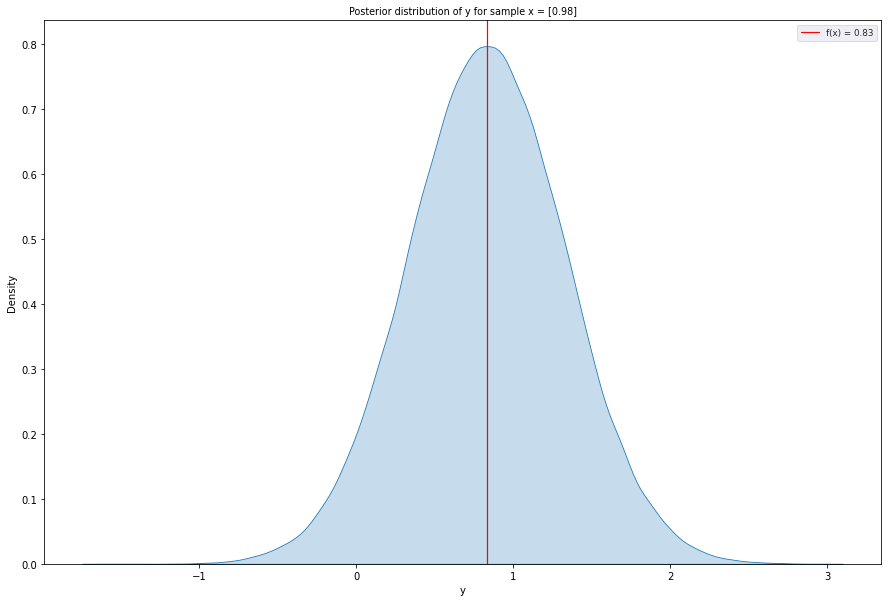

In [5]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [6]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test, y_test = torch.vstack((x_test_in_domain, x_test_out_domain)), torch.vstack((y_test_in_domain, y_test_out_domain))

In [7]:
x_train.shape, y_train.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [8]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=128)

In [9]:
x, y = next(iter(train_dataloader))

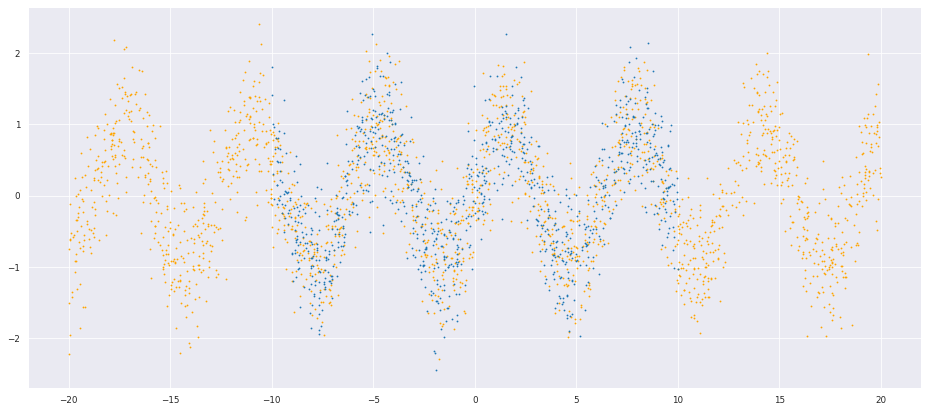

In [10]:

test_sort = torch.argsort(x_test.squeeze())
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1)

In [11]:
net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1))
#net = nn.Linear(1, 1)

In [12]:
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

In [13]:
print(len(x_train))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=PyroParam(torch.tensor(5.), constraint=dist.constraints.positive))
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=dist.Gamma(1.0, 1.0))
#obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x_train), scale=0.5)
#obs_model = tyxe.likelihoods.SigmaDistGaussian(len(x_train), scale_loc=0.01, scale_scale=0.01)

#obs_model = tyxe.likelihoods.LearnableGaussian(len(x_train), scale=5.0)
#obs_model = tyxe.likelihoods.HeteroskedasticGaussian(len(x_train))   #Må ha output 2d

likelihood_guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
#likelihood_guide_builder = None


1000


In [14]:
obs_model._scale

tensor(0.1188)

In [15]:
#guide_builder = poutine.block(partial(tyxe.guides.AutoNormal, init_scale=0.01), hide=["likelihood._scale"])
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)

In [16]:
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder, likelihood_guide_builder=likelihood_guide_builder)

In [17]:
with pyro.poutine.trace() as tr:
    bnn.guide(x)
    print(tr.trace.nodes.keys())
    print(tr.trace.nodes["likelihood._scale"]["value"])
    print(tr.trace.nodes["likelihood_guide.likelihood._scale.loc"]["value"])
    print(tr.trace.nodes["likelihood_guide.likelihood._scale.scale"]["value"])

odict_keys(['net_guide.net.0.weight.loc', 'net_guide.net.0.weight.scale', 'net_guide.net.0.bias.loc', 'net_guide.net.0.bias.scale', 'net_guide.net.2.weight.loc', 'net_guide.net.2.weight.scale', 'net_guide.net.2.bias.loc', 'net_guide.net.2.bias.scale', 'net_guide.net.4.weight.loc', 'net_guide.net.4.weight.scale', 'net_guide.net.4.bias.loc', 'net_guide.net.4.bias.scale', 'net.0.weight', 'net.0.bias', 'net.2.weight', 'net.2.bias', 'net.4.weight', 'net.4.bias', 'likelihood_guide.likelihood._scale.loc', 'likelihood_guide.likelihood._scale.scale', 'likelihood._scale'])
tensor(1.1559, grad_fn=<AddBackward0>)
Parameter containing:
tensor(0.1380, requires_grad=True)
tensor(0.0100, grad_fn=<AddBackward0>)


In [18]:
guide_tr = poutine.trace(bnn.net_guide).get_trace(x)
likelihood_tr = poutine.trace(bnn.likelihood_guide).get_trace(x)
print(likelihood_tr.nodes.keys())
print()
#print(likelihood_tr.nodes["likelihood_guide.likelihood._scale.loc"]["value"])
#print(likelihood_tr.nodes["likelihood_guide.likelihood._scale.scale"]["value"])
#print(likelihood_tr.nodes["likelihood._scale"]["value"])


odict_keys(['_INPUT', 'likelihood_guide.likelihood._scale.loc', 'likelihood_guide.likelihood._scale.scale', 'likelihood._scale', '_RETURN'])



In [19]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-4, "betas": (0.95, 0.999)})
elbos = []
def callback(bnn, i, e):
    if i % 100 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_dataloader, optim, 2000, callback)

epoch: 0 | elbo: 6527.8734130859375
epoch: 100 | elbo: 5948.851745605469
epoch: 200 | elbo: 5777.992492675781
epoch: 300 | elbo: 5625.9923095703125
epoch: 400 | elbo: 5489.396911621094
epoch: 500 | elbo: 5352.3472900390625
epoch: 600 | elbo: 5230.817810058594
epoch: 700 | elbo: 5130.7352294921875
epoch: 800 | elbo: 5021.818542480469
epoch: 900 | elbo: 4928.496887207031
epoch: 1000 | elbo: 4836.8499755859375
epoch: 1100 | elbo: 4735.2149658203125
epoch: 1200 | elbo: 4646.833679199219
epoch: 1300 | elbo: 4574.315246582031
epoch: 1400 | elbo: 4474.415588378906
epoch: 1500 | elbo: 4384.4422607421875
epoch: 1600 | elbo: 4284.880310058594
epoch: 1700 | elbo: 4203.579650878906
epoch: 1800 | elbo: 4115.757507324219
epoch: 1900 | elbo: 4040.8826599121094


In [20]:
bnn.net.state_dict().keys()

odict_keys([])

In [21]:
#pickle.dump(bnn, open(f"{BASE_DIR}/models/{NAME}.pkl", "wb"))

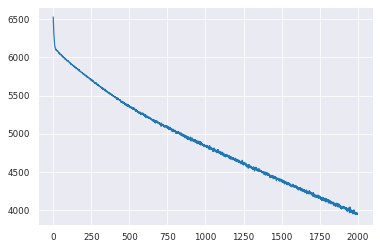

In [22]:
plt.plot(elbos)

In [23]:
trace = poutine.trace(bnn.guide).get_trace(x_test[0], y_test[0])

In [24]:
trace.nodes.keys()
print(trace.nodes["likelihood._scale"])

{'type': 'sample', 'name': 'likelihood._scale', 'fn': TransformedDistribution(), 'is_observed': False, 'args': (), 'kwargs': {}, 'value': tensor(0.5896, grad_fn=<AddBackward0>), 'infer': {}, 'scale': 1.0, 'mask': None, 'cond_indep_stack': (), 'done': True, 'stop': False, 'continuation': None}


In [25]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

# For homoskedastic aggregate True
means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

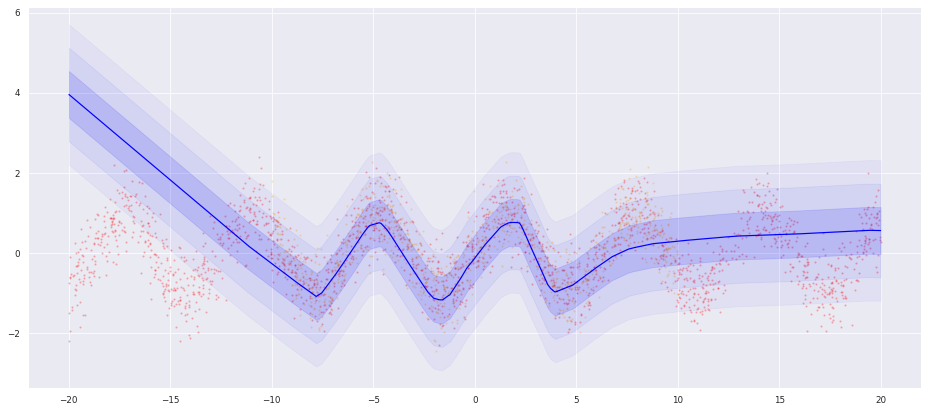

In [26]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

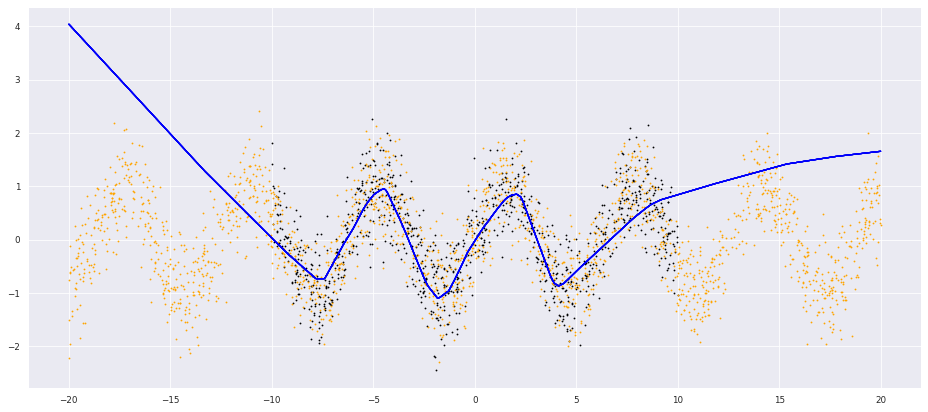

In [27]:


sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_train, y_train, color="black", s=1)
plt.scatter(x_test[test_sort], y_test[test_sort], color="orange", s=1)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [28]:
bnn.get_error_metrics(x_train, y_train, num_predictions=100, reduction="mean")

(tensor(0.4383), tensor(-1.0163), tensor(0.5223))